In [11]:
import math as m
import numpy as np
import random as r
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
import torch
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter

In [3]:
from nflows.flows.base import Flow
from nflows.distributions.uniform import BoxUniform
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from nflows.transforms.permutations import RandomPermutation
from nflows.transforms.splines.rational_quadratic import rational_quadratic_spline
from nflows.transforms.dequantization import UniformDequantization
from nflows.transforms.dequantization import VariationalDequantization

In [4]:
#device = torch.device("cuda:0")
device = torch.device("cpu")

In [12]:
# Make model folder
if not os.path.exists("models"):
    os.makedirs("models")

In [5]:
# Import data and weights
x_data_raw = torch.tensor(pd.read_csv("ee_data.csv", header=None, delimiter=",").to_numpy(), dtype=torch.float32)
x_weights_raw = torch.tensor(pd.read_csv("ee_weights.csv", header=None, delimiter=",").to_numpy(), dtype=torch.float32).squeeze()

# Permute the data
permutation = torch.randperm(x_data_raw.shape[0])
x_data_raw = x_data_raw[permutation]
x_weights_raw = x_weights_raw[permutation]

# Normalize weights by mean
x_weights_raw /= x_weights_raw.mean()

# Chop up the data into training and validation
data_size = x_data_raw.shape[0]
training_size = int(data_size*0.8)

x_data_train    = x_data_raw[:training_size]
x_weights_train = x_weights_raw[:training_size]
x_data_test     = x_data_raw[training_size:]
x_weights_test  = x_weights_raw[training_size:]

# Data dimension
data_dim = x_data_raw.shape[1]

In [6]:
# Determine the maximum labels of discrete dims
max_features = torch.max(x_data_raw, dim=0)[0]
is_discrete = max_features > 1
max_labels = torch.where(max_features > 1, max_features, torch.tensor(-1.))

In [7]:
# Tensorboard writer
writer = SummaryWriter()

In [8]:
num_layers = 6
base_dist_uniform = BoxUniform(torch.zeros(data_dim), torch.ones(data_dim))
base_dist_variational = BoxUniform(torch.zeros(data_dim), torch.ones(data_dim))

transforms_uniform = []
transforms_variational = []

transforms_uniform.append(UniformDequantization(max_labels=max_labels))
transforms_variational.append(VariationalDequantization(max_labels=max_labels, rqs_hidden_features=15, rqs_flow_layers=2))

for _ in range(num_layers):
    transforms_uniform.append(RandomPermutation(features=data_dim))
    transforms_uniform.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        features=data_dim, 
        hidden_features=26,
        num_bins=10,
        num_blocks=4,
    ))

    transforms_variational.append(RandomPermutation(features=data_dim))
    transforms_variational.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        features=data_dim, 
        hidden_features=25,
        num_bins=10,
        num_blocks=4,
    ))

transform_uniform = CompositeTransform(transforms_uniform)
transform_variational = CompositeTransform(transforms_variational)

flow_uniform = Flow(transform_uniform, base_dist_uniform).to(device)
flow_variational = Flow(transform_variational, base_dist_variational).to(device)

optimizer_uniform = optim.Adam(flow_uniform.parameters())
optimizer_variational = optim.Adam(flow_variational.parameters())

In [9]:
# Number of parameters in uniform and variational models
uniform_parameters = filter(lambda p: p.requires_grad, flow_uniform.parameters())
variational_parameters = filter(lambda p: p.requires_grad, flow_variational.parameters())
num_uniform_parameters = sum([np.prod(p.size()) for p in uniform_parameters])
num_variational_parameters = sum([np.prod(p.size()) for p in variational_parameters])

print(num_uniform_parameters, num_variational_parameters)


54564 54778


In [13]:
n_epochs = 25
batch_size = 500
n_batches = m.ceil(x_data_train.shape[0]/batch_size)

for epoch in range(n_epochs):
    permutation = torch.randperm(x_data_train.shape[0], device=device)    

    # Loop over batches
    cum_loss_uniform = 0
    cum_loss_variational = 0
    for batch in range(n_batches):
        # Set up the batch
        batch_begin = batch*batch_size
        batch_end   = min( (batch+1)*batch_size, x_data_train.shape[0]-1 )
        indices = permutation[batch_begin:batch_end]
        x_data_train_batch = x_data_train[indices]
        x_weights_train_batch = x_weights_train[indices]
        
        # Take a step
        optimizer_uniform.zero_grad()
        optimizer_variational.zero_grad()

        loss_uniform = -(flow_uniform.log_prob(inputs=x_data_train_batch)*x_weights_train_batch).mean()
        loss_variational = -(flow_variational.log_prob(inputs=x_data_train_batch)*x_weights_train_batch).mean()

        loss_uniform.backward()
        loss_variational.backward()

        optimizer_uniform.step()
        optimizer_variational.step()

        # Compute cumulative loss
        cum_loss_uniform = (cum_loss_uniform*batch + loss_uniform.item())/(batch+1)
        cum_loss_variational = (cum_loss_variational*batch + loss_variational.item())/(batch+1)
        
        print("epoch = ", epoch, "batch = ",batch+1, "/", n_batches, "loss_uniform = ", cum_loss_uniform, " loss_variational = ", cum_loss_variational)
    
    # Validation log prob
    loss_uniform_validation     = -(flow_uniform.log_prob(inputs=x_data_test)*x_weights_test).mean()
    loss_variational_validation = -(flow_variational.log_prob(inputs=x_data_test)*x_weights_test).mean()

    writer.add_scalar("Loss_train/uniform_loss_train", cum_loss_uniform, epoch)
    writer.add_scalar("Loss_train/variational_loss_train", cum_loss_variational, epoch)

    writer.add_scalar("Loss_test/uniform_loss_test", loss_uniform_validation, epoch)
    writer.add_scalar("Loss_test/variational_loss_test", loss_variational_validation, epoch)

    torch.save(flow_uniform, "models/uniform_model.pt")
    torch.save(flow_variational, "models/variational_model.pt")

epoch =  0 batch =  1 / 2001 loss_uniform =  2.9273412227630615  loss_variational =  3.99845552444458
epoch =  0 batch =  2 / 2001 loss_uniform =  2.4998046159744263  loss_variational =  3.647332191467285
epoch =  0 batch =  3 / 2001 loss_uniform =  2.4276675383249917  loss_variational =  3.5001578330993652
epoch =  0 batch =  4 / 2001 loss_uniform =  2.292385309934616  loss_variational =  3.356385588645935
epoch =  0 batch =  5 / 2001 loss_uniform =  2.058010292053223  loss_variational =  3.1030333995819093
epoch =  0 batch =  6 / 2001 loss_uniform =  1.916174550851186  loss_variational =  2.9042956630388894
epoch =  0 batch =  7 / 2001 loss_uniform =  1.708365878888539  loss_variational =  2.69476648739406
epoch =  0 batch =  8 / 2001 loss_uniform =  1.5859373472630978  loss_variational =  2.479429878294468
epoch =  0 batch =  9 / 2001 loss_uniform =  1.4411790039804246  loss_variational =  2.2615427705976696
epoch =  0 batch =  10 / 2001 loss_uniform =  1.2814264431595803  loss_vari

KeyboardInterrupt: 

In [20]:
n_sample = 10000
with torch.no_grad():
    x_uniform = flow_uniform.sample(n_sample).cpu()
    x_variational = flow_variational.sample(n_sample).cpu()
x_data_plot = x_data_raw.cpu()[:n_sample,:]
x_weights_plot = x_weights_raw.cpu()[:n_sample]

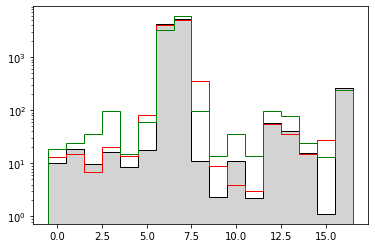

In [21]:
plt.yscale("log")
bins = np.linspace(-0.5, 16.5, 18)
plt.hist(x_data_plot[:,3], histtype='stepfilled', edgecolor="black", facecolor="lightgray", bins=bins, weights=x_weights_plot)
plt.hist(x_uniform[:,3], edgecolor="red", histtype="step", bins = bins)
plt.hist(x_variational[:,3], edgecolor="green", histtype="step", bins = bins)
plt.show()

In [22]:
with torch.no_grad():
    x_uniform_dequantized, _ = flow_uniform._transform._transforms[0].forward(x_uniform)
    x_variational_dequantized, _ = flow_variational._transform._transforms[0].forward(x_variational)

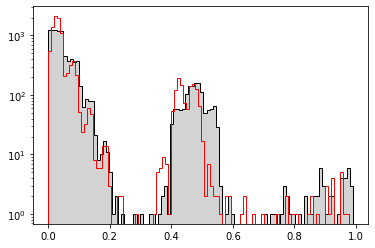

In [26]:
plt.yscale("log")
plt.hist(x_uniform_dequantized[:,2], histtype='stepfilled', edgecolor="black", facecolor="lightgray", bins = 100)
plt.hist(x_variational_dequantized[:,2], edgecolor="red", histtype="step", bins = 100)
plt.show()